In [1]:
# face verification with the VGGFace2 model
import os
import cv2
import logging
import tensorflow
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot
from scipy.spatial.distance import cosine
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

tensorflow.get_logger().setLevel(logging.ERROR)

# load images from received folder
def load_images_from_folder(folder):
    images = []
    
    for filename in os.listdir(folder):
        path_image = os.path.join(folder, filename)
        img = cv2.imread(path_image)
        
        if img is not None:
            images.append(path_image)
            
    return images

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
    # load image from file
    pixels = pyplot.imread(filename)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames, folderlen, size):
    figsize = 2 * size
    # extract faces
    faces = [extract_face(f) for f in filenames]
    
    # create figure (fig), and array of axes (ax)
    fig, ax = pyplot.subplots(nrows=size, ncols=size, figsize=(figsize, figsize))
    # to turn off axes for all subplots    
    [axi.set_axis_off() for axi in ax.ravel()]
    fig.tight_layout(pad=3.5)
    
    # plot simple raster image on each sub-plot
    for i, axi in enumerate(ax.flat):
        # plot the extracted face
        axi.imshow(faces[i])
        axi.set_title(filenames[i][folderlen:-4])
    
    # save the plot
    pyplot.savefig('%s/faces.png' % (folder))
    # show the plot
    pyplot.show() 
        
    # convert into an array of samples
    samples = asarray(faces, 'float32')
    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    # create a vggface model
    model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    # perform prediction
    yhat = model.predict(samples)
    return yhat

# determine if a candidate face is a match for a known face
def is_match(image, known_embedding, candidate_embedding, thresh):
    # calculate distance between embeddings
    score = cosine(known_embedding, candidate_embedding)
    print('\nThe face in the image: %s is:' % (image))
    if score <= thresh:
        print('- a Match (score %.2f <= threshold %.2f)' % (score, thresh))
    else:
        print('- NOT a Match (score %.2f > threshold %.2f)' % (score, thresh))

# checks the image index of the person for whom the verification is performed
def search_name(name, filenames):
    for index in range(len(filenames)):
        if name in filenames[index]:
            return index
    
    return None

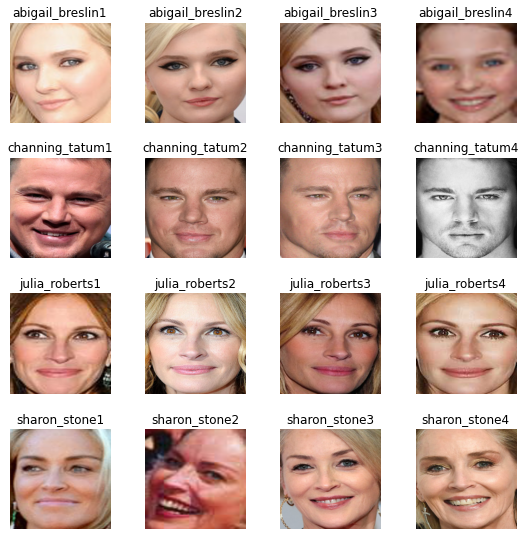

In [2]:
## Main
threshold = 0.5
number_images = 4
folder = '.\data'
folderlen = len(folder) + 1
verify_name = 'sharon_stone'
# define filenames
filenames = load_images_from_folder(folder)
# get embeddings file filenames
embeddings = get_embeddings(filenames, folderlen, number_images)

In [3]:
# checks the image index of the person for whom the verification is performed
index = search_name(verify_name, filenames)
if index == None:
    print('Error! The person for whom the verification was performed isnot included in the input images.')
else: 
    # define sharon stone
    sharon_id = embeddings[index]
    print('\nFor Positive Tests print Match, for Negative Tests print NOT a Match')

# for loop without index 0 in embeddings
for i in range(len(filenames)):
    is_match(filenames[i][folderlen:], sharon_id, embeddings[i], threshold)


For Positive Tests print Match, for Negative Tests print NOT a Match

The face in the image: abigail_breslin1.jpg is:
- NOT a Match (score 0.73 > threshold 0.50)

The face in the image: abigail_breslin2.jpg is:
- NOT a Match (score 0.76 > threshold 0.50)

The face in the image: abigail_breslin3.jpg is:
- NOT a Match (score 0.74 > threshold 0.50)

The face in the image: abigail_breslin4.jpg is:
- NOT a Match (score 0.74 > threshold 0.50)

The face in the image: channing_tatum1.jpg is:
- NOT a Match (score 0.72 > threshold 0.50)

The face in the image: channing_tatum2.jpg is:
- NOT a Match (score 0.74 > threshold 0.50)

The face in the image: channing_tatum3.jpg is:
- NOT a Match (score 0.71 > threshold 0.50)

The face in the image: channing_tatum4.jpg is:
- NOT a Match (score 0.77 > threshold 0.50)

The face in the image: julia_roberts1.jpg is:
- NOT a Match (score 0.67 > threshold 0.50)

The face in the image: julia_roberts2.jpg is:
- NOT a Match (score 0.62 > threshold 0.50)

The fac